# Custom Loss Function

In [1]:
from packaging import version
import tensorflow as tf
import numpy as np

In [2]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

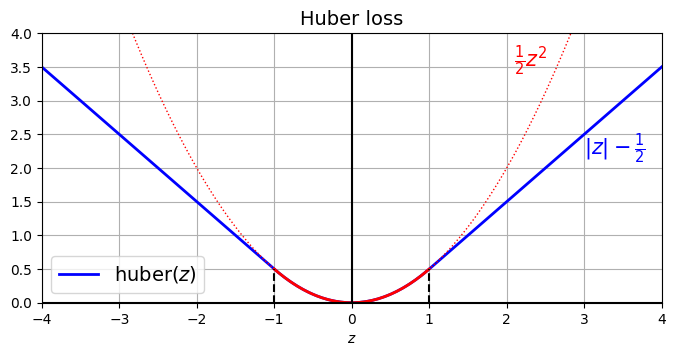

In [3]:


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [4]:


from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [5]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [6]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 18s 8ms/step - loss: 0.6764 - mae: 1.0578 - val_loss: 0.4558 - val_mae: 0.7858
Epoch 2/2
363/363 [==============================] - 3s 8ms/step - loss: 0.2678 - mae: 0.5778 - val_loss: 0.2667 - val_mae: 0.5539


# Saving/Loading Models with Custom Objects

In [7]:
model.save("my_model_with_a_custom_loss") 

In [8]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

In [9]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 9s 9ms/step - loss: 0.2007 - mae: 0.4826 - val_loss: 0.2045 - val_mae: 0.4744
Epoch 2/2
363/363 [==============================] - 3s 7ms/step - loss: 0.1840 - mae: 0.4590 - val_loss: 0.1919 - val_mae: 0.4637


In [10]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [11]:

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [12]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 7s 5ms/step - loss: 0.1998 - mae: 0.4525 - val_loss: 0.2149 - val_mae: 0.4480
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.1942 - mae: 0.4470 - val_loss: 0.1967 - val_mae: 0.4459


In [13]:
model.save("my_model_with_a_custom_loss_threshold_2")

In [14]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_threshold_2",
                                   custom_objects={"huber_fn": create_huber(2.0)})

In [15]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 6ms/step - loss: 0.1901 - mae: 0.4421 - val_loss: 0.1979 - val_mae: 0.4370
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1871 - mae: 0.4382 - val_loss: 0.1819 - val_mae: 0.4361


In [16]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [17]:

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [18]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [19]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.5625 - mae: 0.7756 - val_loss: 0.3047 - val_mae: 0.5743
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2860 - mae: 0.5556 - val_loss: 0.2478 - val_mae: 0.5170


In [20]:
model.save("my_model_with_a_custom_loss_class")  

In [21]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_class",
                                   custom_objects={"HuberLoss": HuberLoss})

In [22]:

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 6ms/step - loss: 0.2399 - mae: 0.5086 - val_loss: 0.2081 - val_mae: 0.4730
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2165 - mae: 0.4807 - val_loss: 0.2398 - val_mae: 0.4840


In [23]:
model.loss.threshold  

2.0

# Custom regularizer, Initializer, Kernel constraint

In [24]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):  # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [25]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

In [26]:


tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 1.5752 - mae: 0.8503 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.8791 - mae: 0.6319 - val_loss: inf - val_mae: inf
Epoch 1/2
363/363 [==============================] - 3s 6ms/step - loss: 0.6237 - mae: 0.5535 - val_loss: 1.6874 - val_mae: 0.5357
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.5274 - mae: 0.5101 - val_loss: 0.9972 - val_mae: 0.5043


In [27]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {"factor": self.factor}

In [28]:

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_regularizer=MyL1Regularizer(0.01),
                          kernel_constraint=my_positive_weights,
                          kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 1.5149 - mae: 0.8675 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.8558 - mae: 0.6377 - val_loss: inf - val_mae: inf
Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.6709 - mae: 0.5677 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 2s 6ms/step - loss: 0.5779 - mae: 0.5284 - val_loss: inf - val_mae: inf


#Custom Metrics

In [29]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [30]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [31]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 1.3793 - huber_fn: 0.5896
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.7194 - huber_fn: 0.3311


### Streaming metrics

In [32]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [33]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [34]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [35]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [36]:
precision.reset_states()

Creating a streaming metric:

In [37]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)  # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [38]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [39]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [40]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [41]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [42]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [43]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [44]:
model.compile(loss=create_huber(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

In [45]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.5431 - huber_metric_1: 0.5431
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2937 - huber_metric_1: 0.2937


In [46]:
model.save("my_model_with_a_custom_metric")

In [47]:
model = tf.keras.models.load_model(
    "my_model_with_a_custom_metric",
    custom_objects={
        "huber_fn": create_huber(2.0),
        "HuberMetric": HuberMetric
    }
)

In [48]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2327 - huber_metric_1: 0.2327
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2051 - huber_metric_1: 0.2051


In [49]:
model.metrics[-1].threshold

2.0

In [50]:
class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

In [51]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [52]:
model.compile(loss=tf.keras.losses.Huber(2.0), optimizer="nadam",
              weighted_metrics=[HuberMetric(2.0)])

In [53]:
np.random.seed(42)
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2,
                    sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.3229 - HuberMetric: 0.6508
Epoch 2/2
363/363 [==============================] - 3s 9ms/step - loss: 0.1710 - HuberMetric: 0.3446


In [54]:
(history.history["loss"][0],
 history.history["HuberMetric"][0] * sample_weight.mean())

(0.32293322682380676, 0.3229332759050881)

In [55]:
model.save("my_model_with_a_custom_metric_v2")

In [56]:
model = tf.keras.models.load_model("my_model_with_a_custom_metric_v2",
                                   custom_objects={"HuberMetric": HuberMetric})

In [57]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2616 - HuberMetric: 0.2616
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2223 - HuberMetric: 0.2223


In [58]:
model.metrics[-1].threshold

2.0

## Custom Layers

In [59]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [60]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787948, 1.        , 2.7182817 ], dtype=float32)>

In [61]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 4s 8ms/step - loss: 0.7015 - val_loss: 0.4179
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4159 - val_loss: 0.3577
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4002 - val_loss: 0.3433
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3883 - val_loss: 0.3624
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3713


0.37126001715660095

In [62]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape)  # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [63]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)
model.save("my_model_with_a_custom_layer")

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 1.7861 - val_loss: 0.8033
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.5740


In [64]:
model = tf.keras.models.load_model("my_model_with_a_custom_layer",
                                   custom_objects={"MyDense": MyDense})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.5296 - val_loss: 0.7590
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.4636 - val_loss: 0.7859


In [65]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  
        return X1 + X2, X1 * X2, X1 / X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape1, batch_input_shape1]

In [66]:
inputs1 = tf.keras.layers.Input(shape=[2])
inputs2 = tf.keras.layers.Input(shape=[2])
MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>)

In [67]:
X1, X2 = np.array([[3., 6.], [2., 7.]]), np.array([[6., 12.], [4., 3.]]) 
MyMultiLayer()((X1, X2))

X1.shape:  (2, 2)  X2.shape:  (2, 2)


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 9., 18.],
        [ 6., 10.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[18., 72.],
        [ 8., 21.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5      , 0.5      ],
        [0.5      , 2.3333333]], dtype=float32)>)

In [68]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [69]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    MyGaussianNoise(stddev=1.0, input_shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 4.3082 - val_loss: 22.8662
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 1.1432


1.1431927680969238

## Custom Models

In [70]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [71]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [72]:
tf.random.set_seed(42)
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)
model.save("my_custom_model")

Epoch 1/2
363/363 [==============================] - 6s 5ms/step - loss: 6.2340
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.7258


In [73]:

model = tf.keras.models.load_model("my_custom_model")
history = model.fit(X_train_scaled, y_train, epochs=2)
model.predict(X_test_scaled[:3])

Epoch 1/2
363/363 [==============================] - 5s 6ms/step - loss: 0.8745
Epoch 2/2
1/1 [==============================] - 0s 96ms/step


array([[0.9165376],
       [1.1038637],
       [3.1368883]], dtype=float32)

In [74]:
tf.random.set_seed(42)
block1 = ResidualBlock(2, 30)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    tf.keras.layers.Dense(1)
])

## Losses and Metrics Based on Model Internals

In [75]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(
            name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)
        self.built = True  

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [76]:
tf.random.set_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
y_pred = model.predict(X_test_scaled)

Epoch 1/5
363/363 [==============================] - 6s 5ms/step - loss: 1.1448 - reconstruction_error: 0.8503
Epoch 2/5
363/363 [==============================] - 2s 6ms/step - loss: 0.4522 - reconstruction_error: 0.5636
Epoch 3/5
363/363 [==============================] - 3s 8ms/step - loss: 0.3971 - reconstruction_error: 0.4448
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.3888 - reconstruction_error: 0.3649
Epoch 5/5
162/162 [==============================] - 0s 2ms/step


## Computing Gradients Using Autodiff

In [77]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [78]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [79]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [80]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [81]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [82]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
try:
    dz_dw2 = tape.gradient(z, w2)  # raises a RuntimeError!
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [83]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # returns tensor 10.0, works fine now!
del tape

In [84]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [85]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [86]:
gradients

[None, None]

In [87]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [88]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [89]:

with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [90]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    z = z1 + z2 + z3

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [91]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [92]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [93]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [94]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  

gradients = tape.gradient(z, [w1, w2])

In [95]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [96]:
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

In [97]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [98]:
x = tf.Variable([1.0e30])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [99]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

In [100]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = backprop'ed from upper layers
        return grads * (1 - 1 / (1 + tf.exp(z)))  # stable grads of softplus

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [101]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

## Custom Training Loops

In [102]:
tf.random.set_seed(42)  
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [103]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [104]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

In [105]:
np.random.seed(42)
tf.random.set_seed(42)

In [106]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [107]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
362/362 - mean: 3.0985 - mean_absolute_error: 0.6494
Epoch 2/5
362/362 - mean: 1.6799 - mean_absolute_error: 0.5293
Epoch 3/5
362/362 - mean: 1.1109 - mean_absolute_error: 0.5042
Epoch 4/5
362/362 - mean: 0.8312 - mean_absolute_error: 0.4959
Epoch 5/5
362/362 - mean: 0.7212 - mean_absolute_error: 0.5005


In [108]:


from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## TensorFlow Functions

In [109]:
def cube(x):
    return x ** 3

In [110]:
cube(2)

8

In [111]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [112]:
tf_cube = tf.function(cube)
tf_cube

In [113]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [114]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [115]:
@tf.function
def tf_cube(x):
    return x ** 3

### TF Functions and Concrete Functions

In [116]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function

<ConcreteFunction tf_cube(x) at 0x7F4A9F1273A0>

In [117]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [118]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [119]:
concrete_function.graph

In [120]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [121]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [122]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [123]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [124]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [125]:
concrete_function.function_def.signature

name: "__inference_tf_cube_518889"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

In [126]:
@tf.function
def tf_cube(x):
    print(f"x = {x}")
    return x ** 3

In [127]:
result = tf_cube(tf.constant(2.0))

x = Tensor("x:0", shape=(), dtype=float32)


In [128]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [129]:
result = tf_cube(2)

x = 2


In [130]:
result = tf_cube(3)

x = 3


In [131]:
result = tf_cube(tf.constant([[1., 2.]]))  # New shape: trace!

x = Tensor("x:0", shape=(1, 2), dtype=float32)


In [132]:
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))  # New shape: trace!

x = Tensor("x:0", shape=(2, 2), dtype=float32)


In [133]:
result = tf_cube(tf.constant([[7., 8.], [9., 10.]]))  # Same shape: no trace

In [134]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)  
    return images[:, ::2, ::2] 

In [135]:
tf.random.set_seed(42)

In [136]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1)  # Works fine, traces the function
preprocessed_images = shrink(img_batch_2)  # Works fine, same concrete function

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [137]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # ValueError! Incompatible inputs
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


### Using Autograph To Capture Control Flow

In [138]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [139]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [140]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

In [141]:

@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [142]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [143]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

In [144]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [145]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [146]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

increment(counter)  # counter is now equal to 1
increment(counter)  # counter is now equal to 2

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [147]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [148]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [149]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [150]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [151]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [152]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [153]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [154]:

def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown(f'```python\n{code}\n```'))

In [155]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

##Custom Optimizers

In [156]:
class MyMomentumOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [157]:
tf.random.set_seed(42)

In [158]:
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])


##Train a model using a custom training loop to tackle the Fashion MNIST dataset

In [159]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

4422102/4422102 [==============================] - 0s 0us/step


In [160]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [161]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [162]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [163]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

In [164]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [165]:
lower_layers = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
])
upper_layers = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="softmax"),
])
model = tf.keras.Sequential([
    lower_layers, upper_layers
])

In [166]:
lower_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

In [167]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [168]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]